In [ ]:
import tensorflow as tf, cv2, albumentations as A, os, numpy as np, matplotlib.pyplot as plt, skimage
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Dropout, BatchNormalization, Conv2DTranspose
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import image_dataset_from_directory, plot_model
from tensorflow.keras.losses import Dice, Tversky
from tensorflow.keras.callbacks import ReduceLROnPlateau as RLR, ModelCheckpoint, EarlyStopping
from tensorflow.keras.metrics import IoU
from keras_tuner.tuners import Hyperband
from sklearn.model_selection import train_test_split
from scipy import ndimage
import pandas as pd

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
os.getcwd()

'/content'

In [ ]:
os.chdir("/content/drive/MyDrive/Senior_Design/image_dataset")

### Setting up model

In [ ]:
# Define the augmentation pipeline
augmentation_pipeline = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
    A.RandomBrightnessContrast(p=0.2)
])

# Function to apply augmentations dynamically
def augment_on_the_fly(image, mask):
    augmented = augmentation_pipeline(image=image, mask=mask)
    return augmented['image'], augmented['mask']

In [ ]:
# Data generator for on-the-fly augmentation
def data_generator(image_paths, mask_paths, batch_size):
    while True:
        for i in range(0, len(image_paths), batch_size):
            batch_images = []
            batch_masks = []
            for j in range(i, min(i + batch_size, len(image_paths))):
                # Load image and mask
                image = cv2.imread(image_paths[j], cv2.COLOR_BGR2RGB)
                mask = cv2.imread(mask_paths[j], cv2.IMREAD_GRAYSCALE)

                # Resize to match input shape
                image = cv2.resize(image, (512, 512))
                mask = cv2.resize(mask, (512, 512))

                # Apply augmentation
                aug_image, aug_mask = augment_on_the_fly(image, mask)

                # Normalize
                aug_image = aug_image / 255.0
                aug_mask = aug_mask[..., np.newaxis] / 255.0  # Add channel dimension

                batch_images.append(aug_image)
                batch_masks.append(aug_mask)

            yield np.array(batch_images, dtype=np.float32), np.array(batch_masks, dtype=np.float32)

In [ ]:
## Lighter Model
## Define a lighter convolutional block
def conv_block(inputs, filters, hp, kernel_size=(3, 3), padding='same',dropout_rate = 0.1):
    x = Conv2D(filters, kernel_size, activation = hp.Choice('activation', values = ['relu', 'elu', 'leaky_relu']), padding=padding)(inputs)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)
    return x

def encoder_block(inputs, filters, hp):
    x = conv_block(inputs, filters, hp)
    p = MaxPooling2D(pool_size=(2, 2))(x)
    return x, p

def decoder_block(inputs, skip_features, filters, hp):
    x = Conv2DTranspose(filters, kernel_size=(2, 2), strides=(2, 2), padding='same')(inputs)
    x = concatenate([x, skip_features])
    x = conv_block(x, filters, hp)
    return x

def multi_scale_unet(hp):
    inputs = Input((512, 512, 3))

    s1, p1 = encoder_block(inputs, hp.Int('encoder_filters_1', 32, 64, step=32),hp)
    s2, p2 = encoder_block(p1, hp.Int('encoder_filters_2', 64, 128, step=64),hp)
    s3, p3 = encoder_block(p2, hp.Int('encoder_filters_3', 128, 256, step=64),hp)
    s4, p4 = encoder_block(p3, hp.Int('encoder_filters_4', 256, 512, step=128),hp)

    # Bridge
    b1 = conv_block(p4, hp.Int('bridge_filters', 256, 512, step=128),hp)

    # Decoder path
    d1 = decoder_block(b1, s4, hp.Int('decoder_filters_1', 256, 512, step=128),hp)
    d2 = decoder_block(d1, s3, hp.Int('decoder_filters_2', 128, 256, step=64),hp)
    d3 = decoder_block(d2, s2, hp.Int('decoder_filters_3', 64, 128, step=64),hp)
    d4 = decoder_block(d3, s1, hp.Int('decoder_filters_4', 32, 64, step=32),hp)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(d4)

    model = Model(inputs, outputs, name="Lighter-Multi-Scale-U-Net")
    model.compile(optimizer=tf.keras.optimizers.Adam(hp.Choice('learning_rate',[1e-3, 1e-4, 1e-5])),
              loss='binary_crossentropy',
              metrics=['accuracy'])
    return model

In [ ]:
# To be completed
tuner = Hyperband(
    multi_scale_unet,
    objective='val_accuracy',
    max_epochs=20,
    factor=3,
    directory='../AI_models',
    project_name='lighter_ms_unet_tune'
)

### Loading images

In [ ]:
image_prefix, mask_prefix = "original/", "mask/"
ip, mp = [image_prefix + n for n in sorted(os.listdir(image_prefix))], [mask_prefix + n for n in sorted(os.listdir(mask_prefix))]

In [ ]:
train_image_paths, test_image_paths, train_mask_paths, test_mask_paths = train_test_split(
    ip, mp, test_size=0.2, random_state=42
)


In [ ]:
# Before training, make sure whether to save the model or not
batch_size = 5

train_gen = data_generator(train_image_paths, train_mask_paths, batch_size)
test_gen = data_generator(test_image_paths, test_mask_paths, batch_size)

steps_per_epoch = len(train_image_paths) // batch_size
validation_steps = len(test_image_paths) // batch_size

In [ ]:
tuner.search(train_gen, validation_data=test_gen, epochs=20, verbose = 1)


Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter
64                |64                |encoder_filters_1
relu              |relu              |activation
128               |128               |encoder_filters_2
192               |192               |encoder_filters_3
512               |512               |encoder_filters_4
384               |384               |bridge_filters
256               |256               |decoder_filters_1
192               |192               |decoder_filters_2
128               |128               |decoder_filters_3
64                |64                |decoder_filters_4
1e-05             |1e-05             |learning_rate
3                 |3                 |tuner/epochs
0                 |0                 |tuner/initial_epoch
2                 |2                 |tuner/bracket
0                 |0                 |tuner/round

Epoch 1/3
   9009/Unknown 4990s 546ms/step - accuracy: 0.8832 - loss: 0.2882

In [ ]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.hypermodel.build(best_hps)
best_model.summary()

In [ ]:
best_model.fit(train_gen, steps_per_epoch=steps_per_epoch, epochs=20, validation_data=test_gen, validation_steps=validation_steps, callbacks = [RLR(factor = 0.1, patience = 5, min_lr = 1e-7)], verbose = 1)

In [ ]:
best_model.save("../AI_models/MS_Unet_Lite_Tuned.keras")

In [ ]:
# Visualization of predictions
def visualize_predictions(model, test_images, test_masks, num_examples=3):
    predictions = model.predict(test_images)
    threshold = 0.5
    for i in range(num_examples):
        plt.figure(figsize=(12, 4))

        # Original Image
        plt.subplot(1, 3, 1)
        plt.title("Original Image")
        plt.imshow(test_images[i])

        # Ground Truth Mask
        plt.subplot(1, 3, 2)
        plt.title("Ground Truth Mask")
        plt.imshow(test_masks[i].squeeze(), cmap='gray')

        # Predicted Mask
        plt.subplot(1, 3, 3)
        plt.title("Predicted Mask")
        binary_pred_mask = (predictions[i] > threshold).astype(np.float32)
        plt.imshow(binary_pred_mask.squeeze(), cmap='gray')

        plt.show()

# Load and preprocess test data for visualization
def load_and_preprocess_test_data(image_paths, mask_paths, input_shape=(512, 512)):
    test_images = []
    test_masks = []
    for img_path, mask_path in zip(image_paths, mask_paths):
        image = cv2.imread(img_path)
        image = cv2.resize(image, input_shape[:2])
        image = image / 255.0

        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, input_shape[:2])
        mask = mask[..., np.newaxis] / 255.0

        test_images.append(image)
        test_masks.append(mask)

    return np.array(test_images, dtype=np.float32), np.array(test_masks, dtype=np.float32)

In [ ]:
# Example usage for visualization
num_examples = 10
test_images, test_masks = load_and_preprocess_test_data(test_image_paths, test_mask_paths)
visualize_predictions(best_model, test_images, test_masks, num_examples)

### Evaluating the best model

In [ ]:
best_model = load_model("../AI_models/MS_Unet_Lite_Tuned.keras")

In [ ]:
best_model.metric_names

### Separate Contours

In [ ]:
def load_and_preprocess_test_data(image_paths, mask_paths, input_shape=(512, 512)):
    test_images = []
    test_masks = []
    for img_path, mask_path in zip(image_paths, mask_paths):
        image = cv2.imread(img_path)
        image = cv2.resize(image, input_shape[:2])
        image = image / 255.0

        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, input_shape[:2])
        mask = mask[..., np.newaxis] / 255.0


        test_images.append(image)
        test_masks.append(mask)

    return np.array(test_images, dtype=np.float32), np.array(test_masks, dtype=np.float32)

In [ ]:
model = load_model("../AI_models/MS_Unet_Lite_1.keras")

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 48 variables whereas the saved optimizer has 94 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
image_prefix, mask_prefix = "original/", "mask/"
ip, mp = [image_prefix + n for n in sorted(os.listdir(image_prefix))], [mask_prefix + n for n in sorted(os.listdir(mask_prefix))]

In [ ]:
train_image_paths, test_image_paths, train_mask_paths, test_mask_paths = train_test_split(
    ip, mp, test_size=0.2, random_state=42
)


In [ ]:
test_images, test_masks = load_and_preprocess_test_data(test_image_paths, test_mask_paths)

In [ ]:
pred = model.predict(test_images)

1/1 ━━━━━━━━━━━━━━━━━━━━ 28s 28s/step


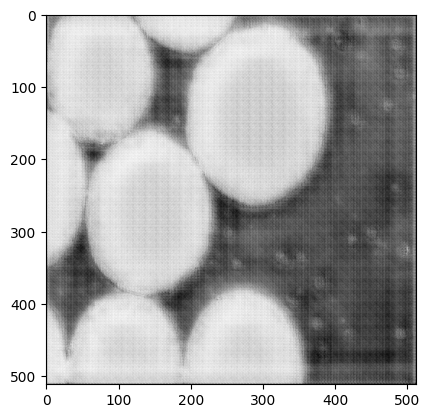

In [ ]:
# DigitalSreeni
plt.imshow(pred[0], cmap = "gray")

In [ ]:
ex_pred = cv2.normalize(pred[0], None, 0, 255, cv2.NORM_MINMAX)
ex_pred = ex_pred.astype(np.uint8)

In [ ]:
_, thresh = cv2.threshold(ex_pred,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

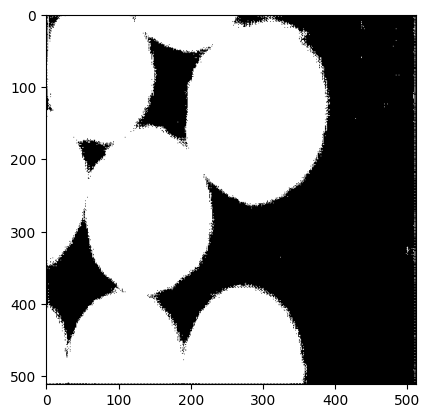

In [ ]:
plt.imshow(thresh, cmap = "grey")

In [ ]:
kernel = np.ones((3,3), np.uint8)
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations = 6)

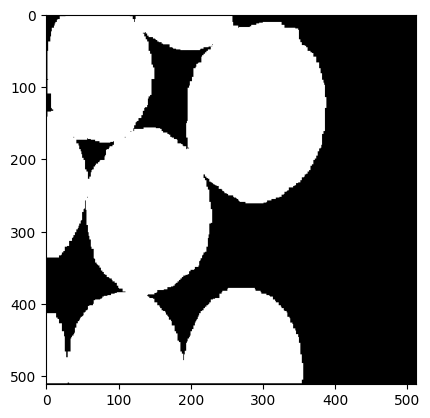

In [ ]:
plt.imshow(opening, cmap = "grey")

In [ ]:
sure_bg = cv2.dilate(opening, kernel, iterations = 8)

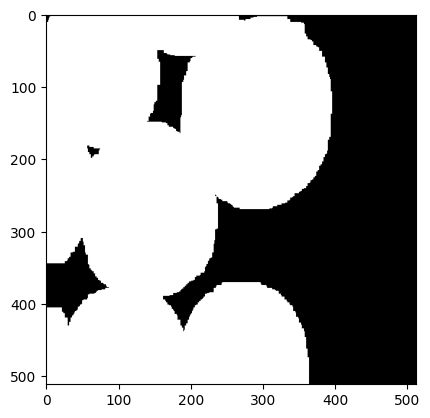

In [ ]:
plt.imshow(sure_bg, cmap = "grey")

In [ ]:
dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)

In [ ]:
_, sure_fg = cv2.threshold(dist_transform, 0.25*dist_transform.max(), 255, 0)

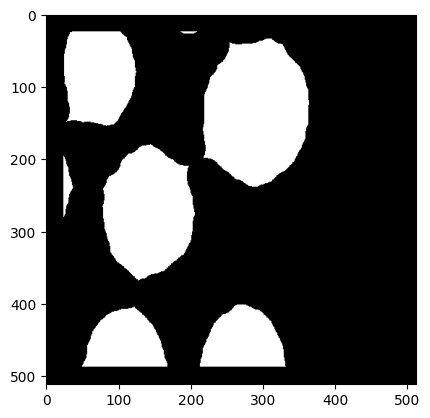

In [ ]:
plt.imshow(sure_fg, cmap = "grey")

In [ ]:
sure_fg = np.uint8(sure_fg)
unk = cv2.subtract(sure_bg, sure_fg)

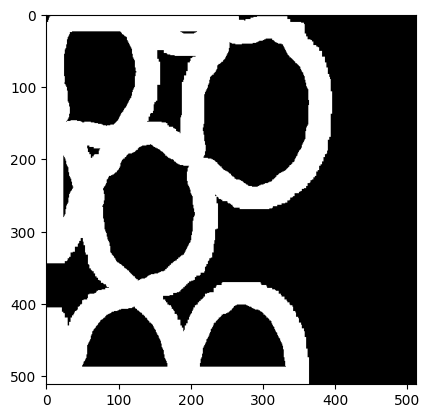

In [ ]:
plt.imshow(unk, cmap = "grey")

In [ ]:
_, markers = cv2.connectedComponents(sure_fg)

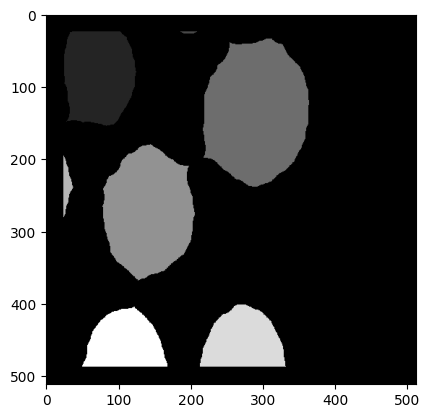

In [ ]:
plt.imshow(markers, cmap = "grey")

In [ ]:
markers = markers + 10

In [ ]:
#Mark the unknown region with 0
markers[unk == 255] = 0

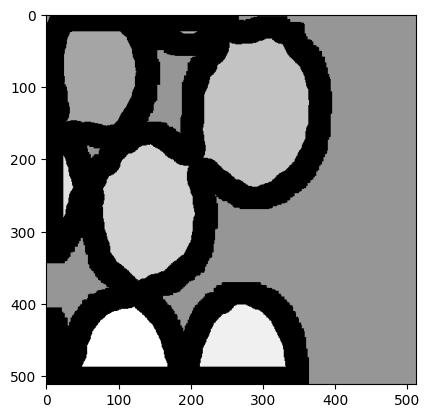

In [ ]:
plt.imshow(markers, cmap = 'gray')

In [ ]:
ex_image = test_images[0].astype(np.uint8)

In [ ]:
markers = cv2.watershed(ex_image,markers)

In [ ]:
ex_image[markers == -1] = [0,0,255]

In [ ]:
ex_image_2 = skimage.color.label2rgb(markers, bg_label = 0)

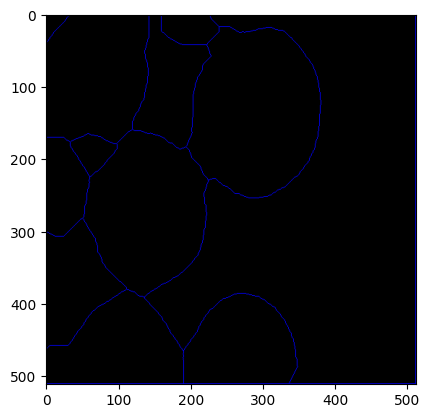

In [ ]:
plt.imshow(ex_image)

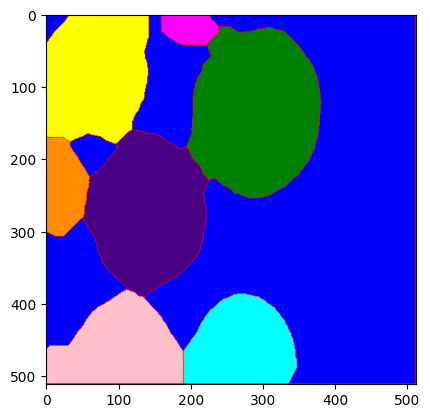

In [ ]:
plt.imshow(ex_image_2)

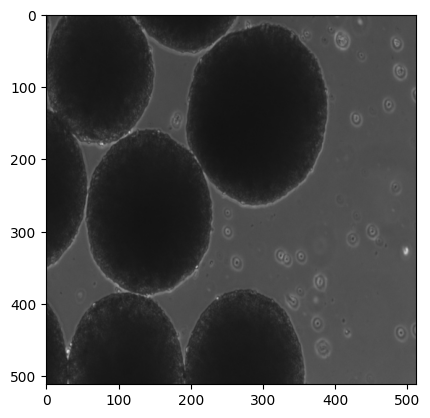

In [ ]:
plt.imshow(test_images[0])

In [ ]:
ex_image3 = cv2.cvtColor(test_images[0], cv2.COLOR_BGR2GRAY)

In [ ]:
properties = ["label", "area", "centroid"]

In [ ]:
props = skimage.measure.regionprops_table(markers, intensity_image = ex_image3, properties = properties)

In [ ]:
df = pd.DataFrame(props)

In [ ]:
print(df)

   label      area  centroid-0  centroid-1
0     10  128744.0  268.467882  338.843752
1     11   22586.0   85.059772   69.496591
2     12    2964.0   20.613698  197.910594
3     13   34898.0  133.591495  288.569717
4     14   28861.0  272.512907  139.797824
5     15    6531.0  239.440361   25.500842
6     16   15750.0  457.047746  269.409016
7     17   17683.0  460.097551   99.933552


Text(0.5, 1.0, 'Labeled Image with Region Properties')

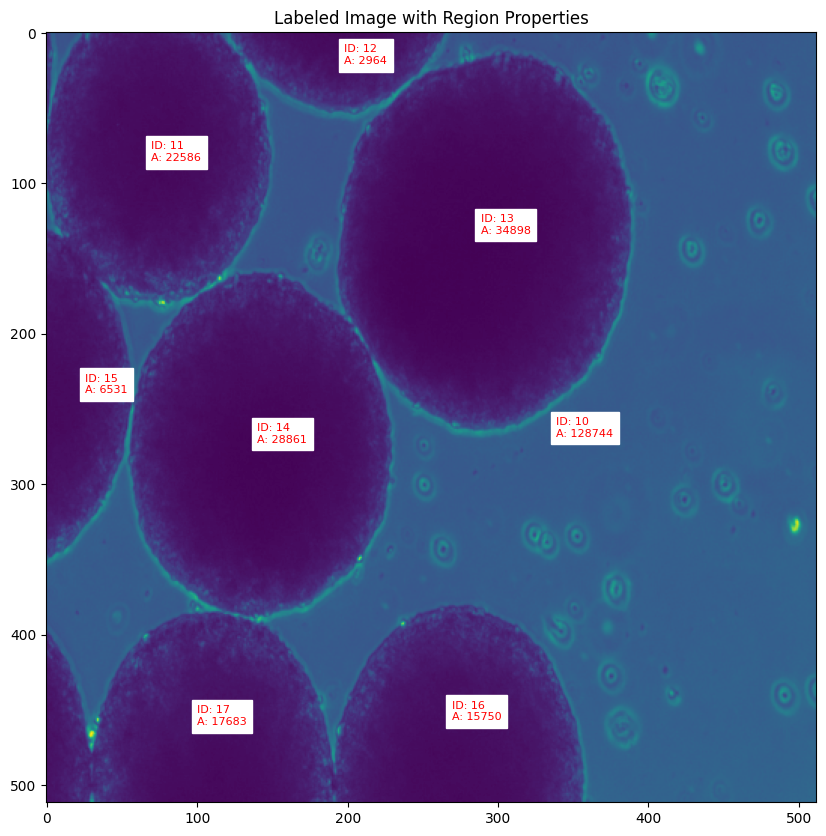

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))

for _, row in df.iterrows():
    # Extract label, centroid, and area from the DataFrame
    label = row["label"]
    cy, cx = row["centroid-0"], row["centroid-1"]  # Centroid coordinates
    area = row["area"]

    # Annotate the label and area
    ax.text(
        cx, cy,
        f"ID: {int(label)}\nA: {int(area)}",
        color="red",
        fontsize=8,
        backgroundcolor="white"
    )

# Display
ax.imshow(ex_image3)
plt.title("Labeled Image with Region Properties")

### Batch Segmentations

In [ ]:
def vis_pred_no_ground(test_images, predictions, num_examples=3):
    threshold = 0.5
    for i in range(num_examples):
        plt.figure(figsize=(12, 4))

        # Original Image
        plt.subplot(1, 2, 1)
        plt.title("Original Image")
        plt.imshow(test_images[i])


        # Predicted Mask
        plt.subplot(1, 2, 2)
        plt.title("Predicted Mask")
        binary_pred_mask = (predictions[i] > threshold).astype(np.float32)
        plt.imshow(binary_pred_mask.squeeze(), cmap='gray')

        plt.show()

In [ ]:
test_img_dir = "test/"

In [ ]:
def load_images(image_dir,input_shape=(512, 512)):
    test_images = []
    for img_path in sorted(os.listdir(image_dir)):
        img_path = image_dir + img_path
        image = cv2.imread(img_path)
        image = cv2.resize(image, input_shape[:2])
        image = image / 255.0
        test_images.append(image)

    return np.array(test_images, dtype=np.float32)

In [ ]:
test_img_new = load_images(test_img_dir)

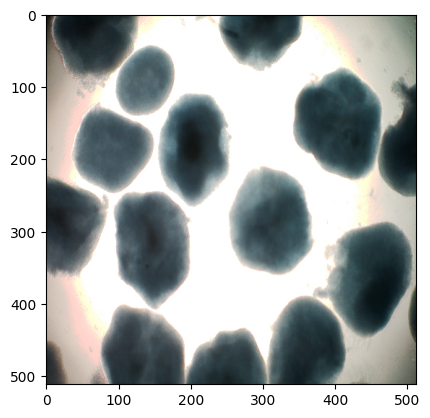

In [ ]:
plt.imshow(test_img_new[0])

In [ ]:
pred_new = model.predict(test_img_new)

2/2 ━━━━━━━━━━━━━━━━━━━━ 58s 16s/step


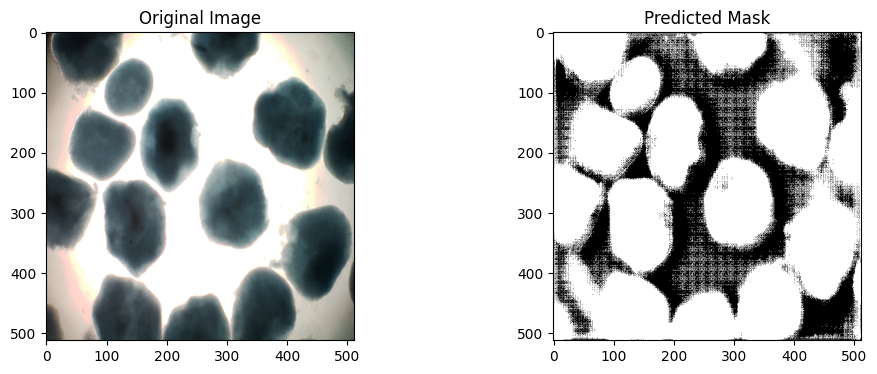

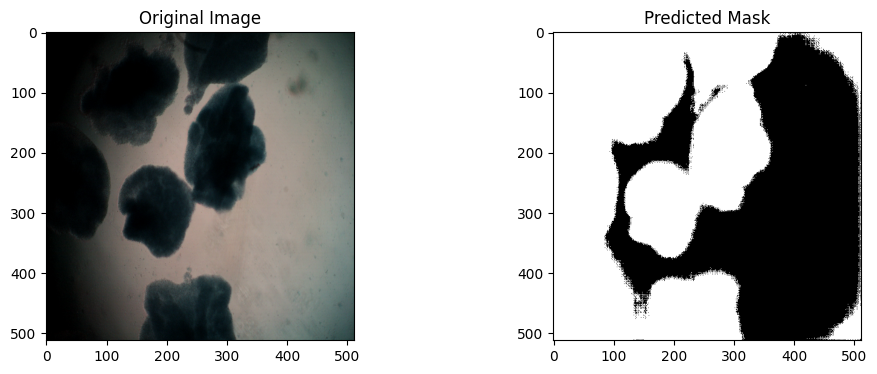

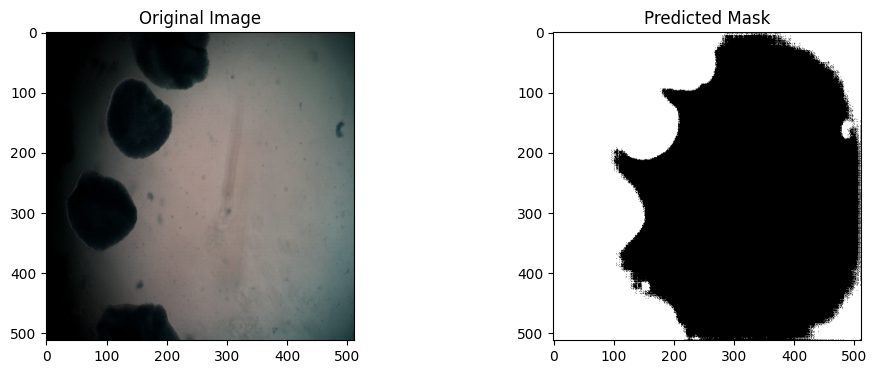

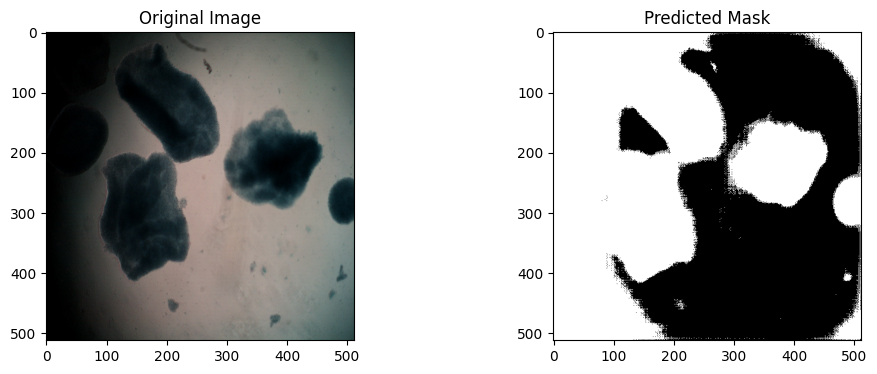

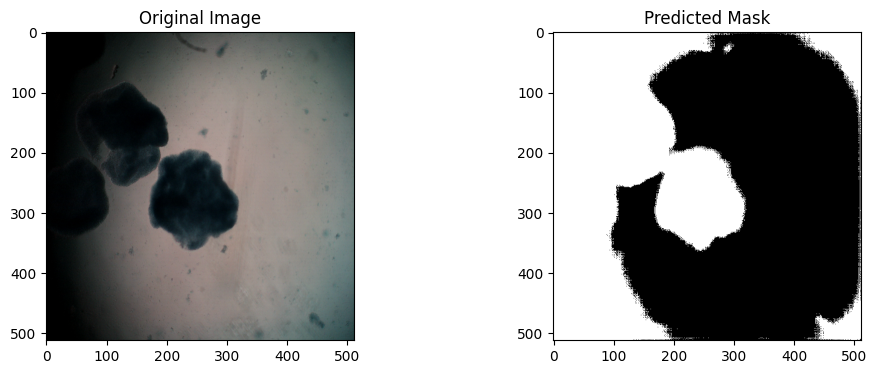

In [ ]:
vis_pred_no_ground(test_img_new, pred_new, 5)

In [ ]:
def seg_pipe(images: np.ndarray, pred: np.ndarray):
  seg_images = np.zeros_like(images)
  b,h,w,c = images.shape
  cell_data = list()
  for i in range(b):
    img, p = images[i], pred[i]
    img_grey = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = img.astype(np.uint8)

    # Normalize and convert
    p = cv2.normalize(p, None, 0, 255, cv2.NORM_MINMAX)
    p = p.astype(np.uint8)

    # Thresholding
    _, thresh = cv2.threshold(p,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

    # Morphological opening
    kernel = np.ones((3,3), np.uint8)
    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations = 6)

    # Dilation to determine sure background
    sure_bg = cv2.dilate(opening, kernel, iterations = 8)

    # Distance transformation
    dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)

    # Determine sure foreground
    _, sure_fg = cv2.threshold(dist_transform, 0.25*dist_transform.max(), 255, 0)

    # Define unknown areas
    sure_fg = np.uint8(sure_fg)
    unk = cv2.subtract(sure_bg, sure_fg)

    # Define markers and set unknown areas = 0
    _, markers = cv2.connectedComponents(sure_fg)
    markers += 10
    markers[unk == 255] = 0

    # Perform Watershed
    markers = cv2.watershed(img,markers)

    # Create color labeled images
    seg_img = skimage.color.label2rgb(markers, bg_label = 0)
    seg_images[i] = seg_img

    # Morphological measurements
    properties = ["label", "area", "centroid"]
    props = skimage.measure.regionprops_table(markers, intensity_image = img_grey, properties = properties)
    df = pd.DataFrame(props)
    cell_data.append(df)

  return seg_images, cell_data

In [ ]:
seg_images, cell_data = seg_pipe(test_img_new, pred_new)

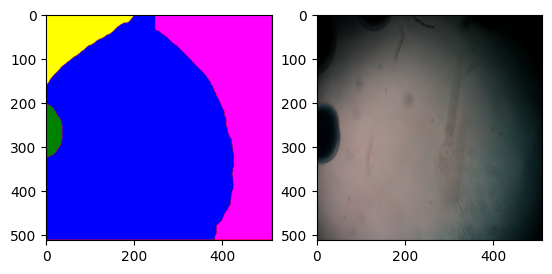

In [ ]:
num = 32
plt.subplot(1,2,1)
plt.imshow(seg_images[num])

plt.subplot(1,2,2)
plt.imshow(test_img_new[num])

plt.show()

In [ ]:
cell_data[num]

,label,area,centroid-0,centroid-1
0,10,173153.0,291.801748,206.035333
1,11,14471.0,48.900007,67.093566
2,12,68394.0,207.408852,431.911235
3,13,3213.0,265.504513,15.477747
